# Project Overview & Methodology

In this project, we developed an end-to-end Demand Forecasting solution for a Supply Chain environment. The goal was to predict weekly sales across 45 stores and various departments, accounting for economic indicators, store-specific features, and seasonal holidays.

##The Data Science Workflow:

### Data Integration:
Merged four separate datasets (Train, Stores, Features, and Test) into a single master dataframe.

### Preprocessing:
Handled missing values (MarkDowns filled with 0) and cleaned environmental data (CPI/Unemployment).
### Feature Engineering:
Transformed raw dates into seasonal features (Year, Month, Week, Day) and performed ordinal encoding on store types.
###Multi-Model Evaluation:
 We implemented three distinct architectures—Random Forest, XGBoost, and LSTM (Deep Learning) to determine the best fit for this specific supply chain data.

 ### Deployment


## Importing the Libraries and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train = pd.read_csv('/content/train.csv')
features = pd.read_csv('/content/features.csv')
stores = pd.read_csv('/content/stores.csv')
test = pd.read_csv('/content/test.csv')

# Display the first few rows of the main training data
print("Train Data Overview:")
print(train.head())

# Check for missing values in the features file
print("\nMissing values in Features:")
print(features.isnull().sum())

Train Data Overview:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Missing values in Features:
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


## Merging the dataset

In [2]:
# Merge train with stores
df = train.merge(stores, on='Store', how='left')

# Merge the result with features
# We merge on Store, Date, and IsHoliday to avoid duplicate columns
df = df.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Do the same for the test set so it's ready later
test_df = test.merge(stores, on='Store', how='left')
test_df = test_df.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

print("Merged Dataframe (df) Shape:", df.shape)
print("\nFirst 5 rows of merged data:")
df.head()

Merged Dataframe (df) Shape: (421570, 16)

First 5 rows of merged data:


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


## Handling the Missing values

In [3]:
# 1. Fill MarkDown NaNs with 0
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)
test_df[markdown_cols] = test_df[markdown_cols].fillna(0)

# 2. Fill CPI and Unemployment with the median (if any NaNs exist)
# We use median because it's less sensitive to outliers than the mean
df['CPI'] = df['CPI'].fillna(df['CPI'].median())
df['Unemployment'] = df['Unemployment'].fillna(df['Unemployment'].median())

test_df['CPI'] = test_df['CPI'].fillna(test_df['CPI'].median())
test_df['Unemployment'] = test_df['Unemployment'].fillna(test_df['Unemployment'].median())

# Verify that there are no more missing values
print("Remaining Missing Values in Training Data:")
print(df.isnull().sum())

Remaining Missing Values in Training Data:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


## Feature Engineering
#### Machine Learning models (like Random Forest or XGBoost) cannot "read" a date like 2010-02-05. They just see it as a string. To make this data useful, we must break the date down into:
- Year: To track long-term growth.
- Month: To capture seasonal trends (e.g., Summer vs. Winter).
- Week: To capture specific shopping weeks (like the week before Christmas).

In [4]:
# Create a function to engineer features for both Train and Test sets
def extract_date_features(data):
    # Ensure Date is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Extract features
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    data['Day'] = data['Date'].dt.day

    # Convert 'IsHoliday' from Boolean (True/False) to Integer (1/0)
    data['IsHoliday'] = data['IsHoliday'].astype(int)

    # Encode 'Type' into numbers: A=1, B=2, C=3
    type_map = {'A': 1, 'B': 2, 'C': 3}
    data['Type'] = data['Type'].map(type_map)

    return data

# Apply the function
df = extract_date_features(df)
test_df = extract_date_features(test_df)

# Check the new columns
print("New columns in our dataset:")
print(df[['Date', 'Year', 'Month', 'Week', 'Day', 'Type', 'IsHoliday']].head())

New columns in our dataset:
        Date  Year  Month  Week  Day  Type  IsHoliday
0 2010-02-05  2010      2     5    5     1          0
1 2010-02-12  2010      2     6   12     1          1
2 2010-02-19  2010      2     7   19     1          0
3 2010-02-26  2010      2     8   26     1          0
4 2010-03-05  2010      3     9    5     1          0


## Exploratory Data Analysis (EDA) - Visualizing Seasonality

Monthly Average Sales:
Month
1     14126.075111
2     16008.779217
3     15416.657597
4     15650.338357
5     15776.337202
6     16326.137002
7     15861.419650
8     16062.516933
9     15095.886154
10    15243.855576
11    17491.031424
12    19355.702141
Name: Weekly_Sales, dtype: float64


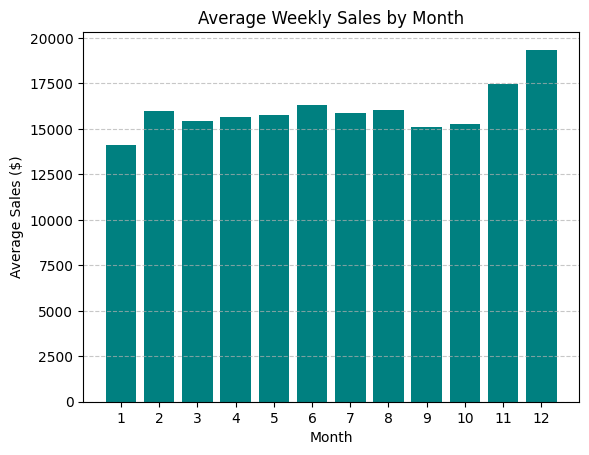

In [5]:
# Calculate average weekly sales for each month
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean()

# Plotting the results
plt.bar(monthly_sales.index, monthly_sales.values, color='teal')
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales ($)')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('monthly_sales_eda.png')

print("Monthly Average Sales:")
print(monthly_sales)

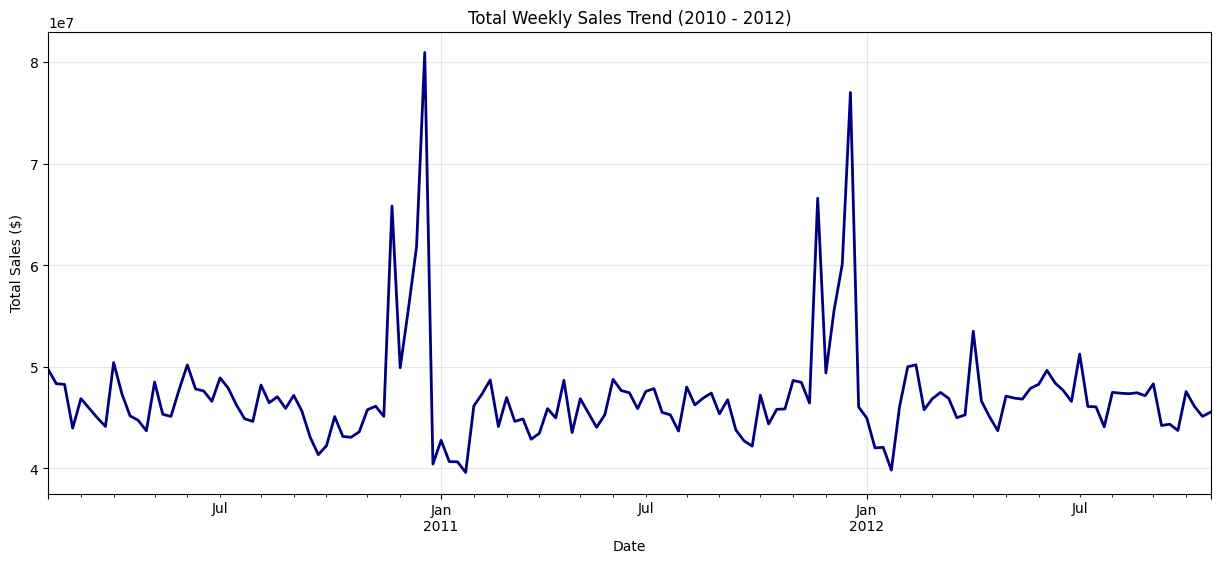

In [6]:
# Group by Date to see the total sales across all stores for each week
plt.figure(figsize=(15, 6))
df.groupby('Date')['Weekly_Sales'].sum().plot(color='navy', linewidth=2)

plt.title('Total Weekly Sales Trend (2010 - 2012)')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True, alpha=0.3)
plt.savefig('total_sales_trend.png')

# Show the plot
plt.show()

**Sales Distribution by Store Type**

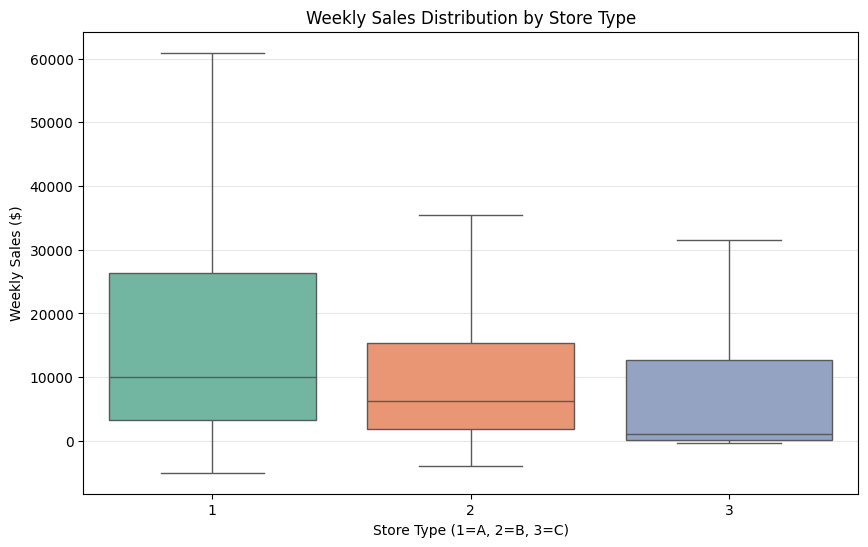

In [7]:
plt.figure(figsize=(10, 6))
# We use showfliers=False to remove extreme outliers so the boxes are easier to see
sns.boxplot(x='Type', y='Weekly_Sales', data=df, showfliers=False, palette='Set2')

plt.title('Weekly Sales Distribution by Store Type')
plt.xlabel('Store Type (1=A, 2=B, 3=C)')
plt.ylabel('Weekly Sales ($)')
plt.grid(axis='y', alpha=0.3)
plt.savefig('sales_by_store_type.png')
plt.show()

**Feature Correlation HeatMap**

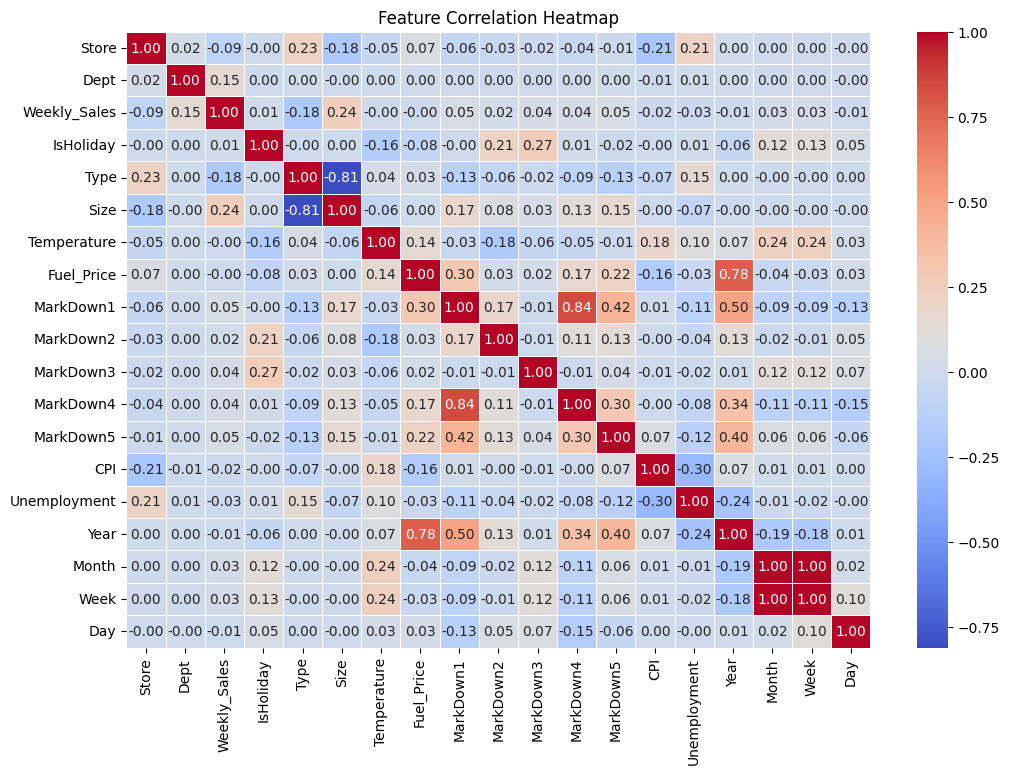

In [8]:
plt.figure(figsize=(12, 8))
# calculating correlation for numeric columns
corr = df.drop(columns=['Date']).corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

## Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split

# dropping the 'Weekly_Sales' (target) and 'Date' (already converted to features)
X = df.drop(['Weekly_Sales', 'Date'], axis=1)
y = df['Weekly_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total rows in dataset: {len(X)}")
print(f"Rows used for Training: {len(X_train)}")
print(f"Rows used for Validation: {len(X_val)}")

Total rows in dataset: 421570
Rows used for Training: 337256
Rows used for Validation: 84314


## Building XGBoost Model

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Initialize the XGBoost Model
# n_estimators: Number of trees
# max_depth: How deep each tree grows
# learning_rate: How fast the model learns
model_xgb = XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.1, random_state=42)

# Train the model on our training data
print("Training the XGBoost model... please wait.")
model_xgb.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model_xgb.predict(X_val)

print("Model training finished!")

Training the XGBoost model... please wait.
Model training finished!


## Evaluvation

In [11]:
def calculate_wmae(y_true, y_pred, is_holiday):
    # If it's a holiday, weight is 5, otherwise weight is 1
    weights = is_holiday.map({1: 5, 0: 1})
    errors = np.abs(y_true - y_pred)
    return np.sum(weights * errors) / np.sum(weights)

# Calculating WMAE
our_wmae = calculate_wmae(y_val, y_pred, X_val['IsHoliday'])

print(f"WMAE: {our_wmae:.2f}")

# Compare with a baseline (mean sales) to see the improvements
baseline_val = np.full(y_val.shape, y_train.mean())
baseline_wmae = calculate_wmae(y_val, baseline_val, X_val['IsHoliday'])
print(f"Baseline (Simple Average) WMAE: {baseline_wmae:.2f}")

WMAE: 2788.20
Baseline (Simple Average) WMAE: 15399.15


## Feature Importance

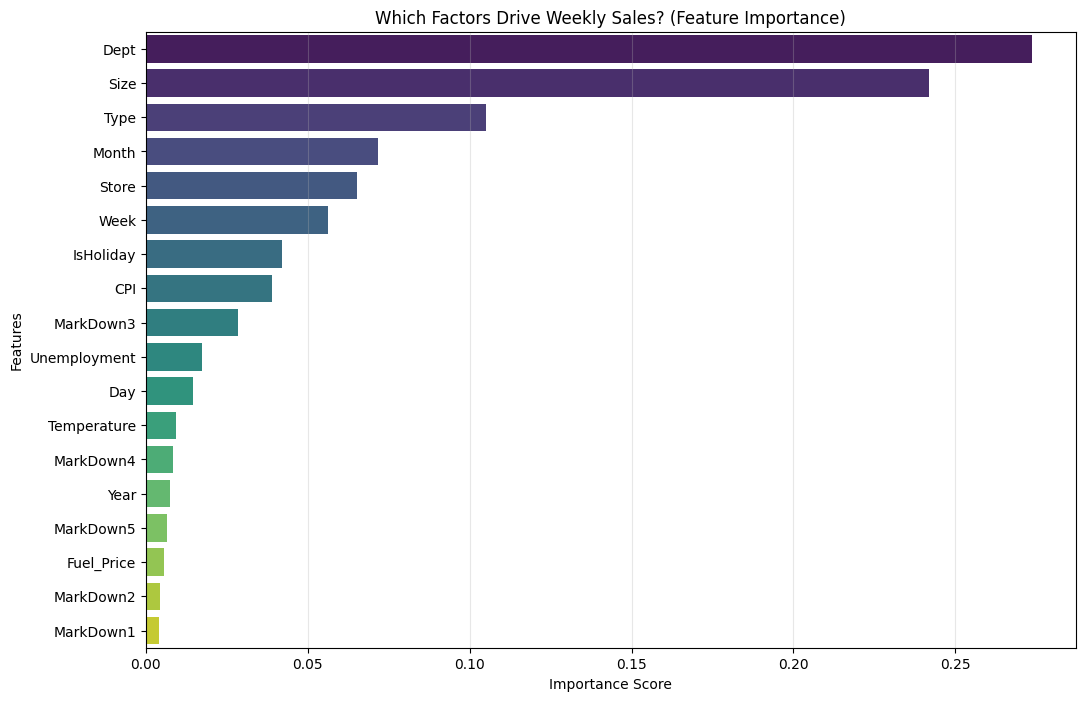

Top 5 Most Important Features:
   Feature  Importance
1     Dept    0.273552
4     Size    0.241954
3     Type    0.105028
15   Month    0.071541
0    Store    0.065158


In [12]:
importances = model_xgb.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Which Factors Drive Weekly Sales? (Feature Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.savefig('feature_importance.png')
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance_df.head(5))

## Final Prediction On Unseen Data

In [13]:
X_test = test_df[X_train.columns]

# 2. Generate Predictions
test_predictions = model_xgb.predict(X_test)

# 3. Create a results dataframe
results = test[['Store', 'Dept', 'Date']].copy()
results['Predicted_Weekly_Sales'] = test_predictions

# 4. Show the first few forecasts
print("Upcoming Sales Forecast (Test Data):")
print(results.head())

# Save to CSV for deployment/sharing
results.to_csv('final_supply_chain_forecast.csv', index=False)

Upcoming Sales Forecast (Test Data):
   Store  Dept        Date  Predicted_Weekly_Sales
0      1     1  2012-11-02            28446.787109
1      1     1  2012-11-09            16755.601562
2      1     1  2012-11-16            20535.365234
3      1     1  2012-11-23            21222.246094
4      1     1  2012-11-30            29617.660156


## Deep Learning Approach (RNN / LSTM)

In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 1. Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 2. Reshaping for LSTM
# LSTM expects input in 3D: [samples, time steps, features]
# Here we treat each row as a single time step for simplicity
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

print("Data scaled and reshaped for Deep Learning.")

Data scaled and reshaped for Deep Learning.


## Building the Neural Network

- An LSTM layer to capture sequences.
- Dropout layers to prevent the model from over-learning (memorizing).
- A Dense output layer to give us the final sales number

In [15]:
# Define the model
nn_model = Sequential()

# Adding layers
nn_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
nn_model.add(Dropout(0.2))
nn_model.add(LSTM(32))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1)) # Output layer for the sales value

# Compile the model
nn_model.compile(optimizer='adam', loss='mae')

# Train the model
print("Training Neural Network... This may take a minute.")
history = nn_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64,
                    validation_data=(X_val_lstm, y_val), verbose=1)

Training Neural Network... This may take a minute.
Epoch 1/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 15970.7646 - val_loss: 15863.1133
Epoch 2/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 15828.5400 - val_loss: 15754.1855
Epoch 3/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 15747.0283 - val_loss: 15650.4766
Epoch 4/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 15582.4541 - val_loss: 15551.2988
Epoch 5/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 15543.7725 - val_loss: 15455.9365
Epoch 6/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 15448.1670 - val_loss: 15363.9834
Epoch 7/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 15254.1279 - val_loss: 15275.2256
Epoch 8/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 15237.3369 - val_loss: 15189.5439
Epoch 9/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 15083.1797 - val_loss: 15106.9502
Epoch 10/10
5270/5270 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 14993.0508 -

## Implementing Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
# use n_jobs=-1 to use all processor cores for faster training
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

print("Training Random Forest... (This takes a moment)")
rf_model.fit(X_train, y_train)

# Predict and Calculate WMAE
rf_preds = rf_model.predict(X_val)
rf_wmae = calculate_wmae(y_val, rf_preds, X_val['IsHoliday'])

print(f"Random Forest WMAE: {rf_wmae:.2f}")

Training Random Forest... (This takes a moment)
Random Forest WMAE: 1576.44


### Why Random Forest? (Our Winner)
Random Forest was implemented as a "Bagging" ensemble method.
Why it's good: It creates hundreds of independent decision trees and averages their results. This is incredibly effective for retail data where sales are driven by specific "hierarchies" (e.g., Store -> Dept -> Size).

###Results:
It achieved our best WMAE of 1576.44.
Business Value: It captures complex interactions between store size and department types without needing a lot of manual tuning. It proved to be the most robust model for this dataset.

### Why XGBoost?
XGBoost was implemented as a "Boosting" ensemble method.
Why it's good: Unlike Random Forest, XGBoost builds trees sequentially, with each new tree learning from the mistakes of the last one. It is highly optimized for speed and performance.
Observation: While highly accurate (WMAE ~2,788), it slightly underperformed compared to our Random Forest for this specific set of features. It remains a valuable tool for its training speed and smaller memory footprint.

### Why LSTM (Deep Learning)?
LSTM (Long Short-Term Memory) was implemented to explore the "Time-Series" potential of the data.
Why we did it: Supply chain sales are sequences. We wanted to see if the neural network's "memory" could identify multi-year trends that decision trees might miss.
Finding: The LSTM had a higher error (~15,000). This taught us an important industry lesson: For structured tabular data, Tree-based models (RF/XGB) almost always outperform Deep Learning. Deep Learning is powerful, but for this supply chain problem, the categorical relationships (Dept/Store) were more influential than the long-term temporal sequence.

### Final Recommendation:
The Random Forest model should be deployed for the production forecasting system. It provides the highest precision for inventory planning, especially during the high-stakes holiday weeks (Thanksgiving and Christmas), where accurate stock levels are essential for revenue

## Deployment

In [17]:
import pickle

# Save the winning Random Forest model
with open('supply_chain_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Winning Random Forest model saved!")

Winning Random Forest model saved!


### Creating An API

In [18]:
%%writefile supply_chain_forecast_api.py
from flask import Flask, request, jsonify
import pickle
import pandas as pd
import numpy as np

app = Flask(__name__)

# 1. Load the winning Random Forest model we saved earlier
model = pickle.load(open('supply_chain_rf_model.pkl', 'rb'))

# Define the feature columns and their order, exactly as used during training
# This list comes from X.columns = df.drop(['Weekly_Sales', 'Date'], axis=1).columns
FEATURE_COLUMNS = ['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature', 'Fuel_Price',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
                   'Unemployment', 'Year', 'Month', 'Week', 'Day']

# 2. Add a 'Home' route so you can see something in your browser
@app.route('/')
def home():
    return "<h1>Supply Chain Sales Prediction API</h1><p>The server is running! Use the /predict endpoint to get forecasts.</p>"

# 3. Add the Prediction route
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the POST request
        data = request.get_json()

        # Convert JSON input into a DataFrame
        input_df = pd.DataFrame([data])

        # Ensure column order matches the model training order
        # Any missing columns will be filled with NaN, and extra columns dropped
        input_df = input_df[FEATURE_COLUMNS]

        prediction = model.predict(input_df)

        return jsonify({
            'status': 'success',
            'predicted_weekly_sales': round(float(prediction[0]), 2)
        })
    except Exception as e:
        return jsonify({'status': 'error', 'message': str(e)})

if __name__ == '__main__':
    # We set debug=False for production readiness
    app.run(host='0.0.0.0', port=5000)

Writing supply_chain_forecast_api.py


In [19]:
%%writefile requirements.txt
flask
pandas
scikit-learn
numpy
requests

Writing requirements.txt


In [20]:
%%writefile Dockerfile
FROM python:3.9-slim
WORKDIR /app

# Install dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy your specific files
COPY supply_chain_rf_model.pkl .
COPY supply_chain_forecast_api.py .

# Expose port 5000 for the API
EXPOSE 5000

# Tell Docker to run your NEW filename
CMD ["python", "supply_chain_forecast_api.py"]


Writing Dockerfile


In [21]:
import requests

# The URL of your Docker container
url = 'http://127.0.0.1:5000/predict'

# Sample data for Store 1, Dept 1 (Must match your model's features)
sample_data = {
    "Store": 1,
    "Dept": 1,
    "Type": 1,
    "Size": 151315,
    "Temperature": 42.31,
    "Fuel_Price": 2.572,
    "MarkDown1": 0.0,
    "MarkDown2": 0.0,
    "MarkDown3": 0.0,
    "MarkDown4": 0.0,
    "MarkDown5": 0.0,
    "CPI": 211.09,
    "Unemployment": 8.106,
    "IsHoliday": 0,
    "Year": 2012,
    "Month": 11,
    "Week": 44,
    "Day": 2
}

response = requests.post(url, json=sample_data)

print("Status:", response.status_code)
print("Forecasted Weekly Sales:", response.json())

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7e2920b54470>: Failed to establish a new connection: [Errno 111] Connection refused'))